In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [2]:
import math
from torch.utils.data import DataLoader

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [4]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(in_channels=2,embedding_size=64,k=5)
        self.positional_embedding = torch.nn.Embedding(512,64)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=64,nhead=8, dim_feedforward=1024)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3) 
        
        self.fc1 = torch.nn.Linear(64,1)
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1) 

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z).permute(2,0,1) 
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2) 
        input_embedding = z_embedding+positional_embeddings 
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks) 

        output = self.fc1(transformer_embedding.permute(1,0,2))
        return output
        

In [5]:
t0 = 140

In [6]:
train_dataset = Dataloader.time_series_decoder_paper(t0,4500)
test_dataset = Dataloader.time_series_decoder_paper(t0,1000)
validation_dataset = Dataloader.time_series_decoder_paper(t0,500)

x: 4500*240 fx: 4500*240
x: 1000*240 fx: 1000*240
x: 500*240 fx: 500*240


In [7]:
criterion = torch.nn.MSELoss()

In [8]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [9]:
model = TransformerTimeSeries().cuda()

d:\Bestanden\Documenten\GitHub\Transformer_Time_Series\.venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
lr = .0005 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
epochs = 300

In [11]:
def Dp(y_pred,y_true,q): # p-quantile loss helper function
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])


In [12]:
def Rp_num_den(y_preds,y_trues,q): # p-quantile loss helper function 2
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [13]:
def train_epoch(model,train_dl,t0=96):
    model.train()
    train_loss = 0
    train_mape = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

        preds = output.squeeze()[:,(t0-1):(t0+100-1)]
        targets =y.cuda()[:,t0:]

        loss = criterion(preds,targets) # not missing data
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        train_mape += mean_absolute_percentage_error(targets.detach().cpu(), preds.detach().cpu()).item() * x.shape[0]
        n += x.shape[0]
    return train_loss/n, train_mape/n # return the average loss 

In [14]:
def eval_epoch(model,validation_dl,t0=96):
    model.eval()
    eval_loss = 0
    eval_mape = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            preds = output.squeeze()[:,(t0-1):(t0+100-1)]
            targets = y.cuda()[:,t0:]

            loss = criterion(preds, targets)
            
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            eval_mape += mean_absolute_percentage_error(targets.detach().cpu(), preds.detach().cpu()).item() * x.shape[0]

            n += x.shape[0]
            
    return eval_loss/n, eval_mape/n # return the average loss

In [15]:
def test_epoch(model,test_dl,t0=96):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            for p,o in zip(output.squeeze()[:,(t0-1):(t0+100-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()):


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp

In [16]:
train_epoch_loss = []
eval_epoch_loss = []
train_epoch_mape = []
eval_epoch_mape = []

Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    train_mape = []
    eval_mape = []

    
    l_t, l_t_mape = train_epoch(model,train_dl,t0)
    train_loss.append(l_t)
    train_mape.append(l_t_mape)
    
    l_e, l_e_mape = eval_epoch(model,validation_dl,t0)
    eval_loss.append(l_e)
    eval_mape.append(l_e_mape)
    
    Rp = test_epoch(model,test_dl,t0)

    if Rp_best > Rp:
        Rp_best = Rp
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    
    print(f"Epoch {e}: Train loss: {np.mean(train_loss):.4f} \t Val loss: {np.mean(eval_loss):.4f} \t "
      f"Train MAPE: {np.mean(train_mape):.2f}% \t Val MAPE: {np.mean(eval_mape):.2f}% \t R_p = {Rp:.4f}")


Epoch 0: Train loss: 8907.4830 	 Val loss: 8492.3389 	 Train MAPE: 530.03% 	 Val MAPE: 382.86% 	 R_p = 0.9432
Epoch 1: Train loss: 7799.7521 	 Val loss: 7183.5268 	 Train MAPE: 200.64% 	 Val MAPE: 79.86% 	 R_p = 0.7979
Epoch 2: Train loss: 6586.6433 	 Val loss: 5970.1106 	 Train MAPE: 137.93% 	 Val MAPE: 82.48% 	 R_p = 0.7157
Epoch 3: Train loss: 5366.0005 	 Val loss: 4736.0246 	 Train MAPE: 163.88% 	 Val MAPE: 71.03% 	 R_p = 0.6011
Epoch 4: Train loss: 4180.6522 	 Val loss: 3631.8198 	 Train MAPE: 148.72% 	 Val MAPE: 64.72% 	 R_p = 0.5117
Epoch 5: Train loss: 3144.7997 	 Val loss: 2672.6999 	 Train MAPE: 98.45% 	 Val MAPE: 54.95% 	 R_p = 0.4229
Epoch 6: Train loss: 2277.9187 	 Val loss: 1901.3988 	 Train MAPE: 126.91% 	 Val MAPE: 42.61% 	 R_p = 0.3474
Epoch 7: Train loss: 1591.0365 	 Val loss: 1300.9091 	 Train MAPE: 95.57% 	 Val MAPE: 36.64% 	 R_p = 0.2753
Epoch 8: Train loss: 1076.9224 	 Val loss: 871.7256 	 Train MAPE: 91.27% 	 Val MAPE: 40.65% 	 R_p = 0.2230
Epoch 9: Train loss: 7

In [17]:
print("Rp best={}".format(Rp_best))

# Evaluate the model on the test set
model.eval()
predictions = []
observations = []

with torch.no_grad():
    for step,(x,y,attention_masks) in enumerate(test_dl):
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

        for p,o in zip(output.squeeze()[:,(t0-1):(t0+100-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()):
            predictions.append(p)
            observations.append(o)

# Print the MSE and MAPE
mse = np.mean((np.array(predictions) - np.array(observations))**2)
mape = np.mean(np.abs((np.array(predictions) - np.array(observations)) / (np.array(observations) + 1e-8))) * 100
print(f"Test MSE: {mse:.4f} \t Test MAPE: {mape:.3f}%")

Rp best=0.010276635169562667
Test MSE: 1.0317 	 Test MAPE: 42.248%


## Visualize the data

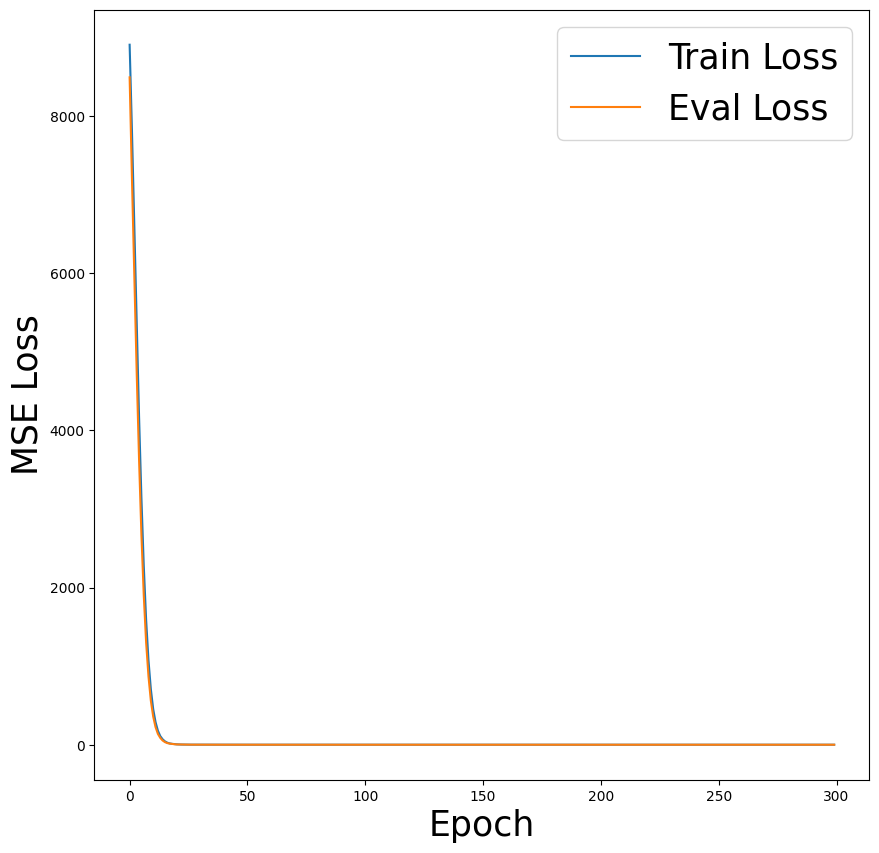

In [18]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()

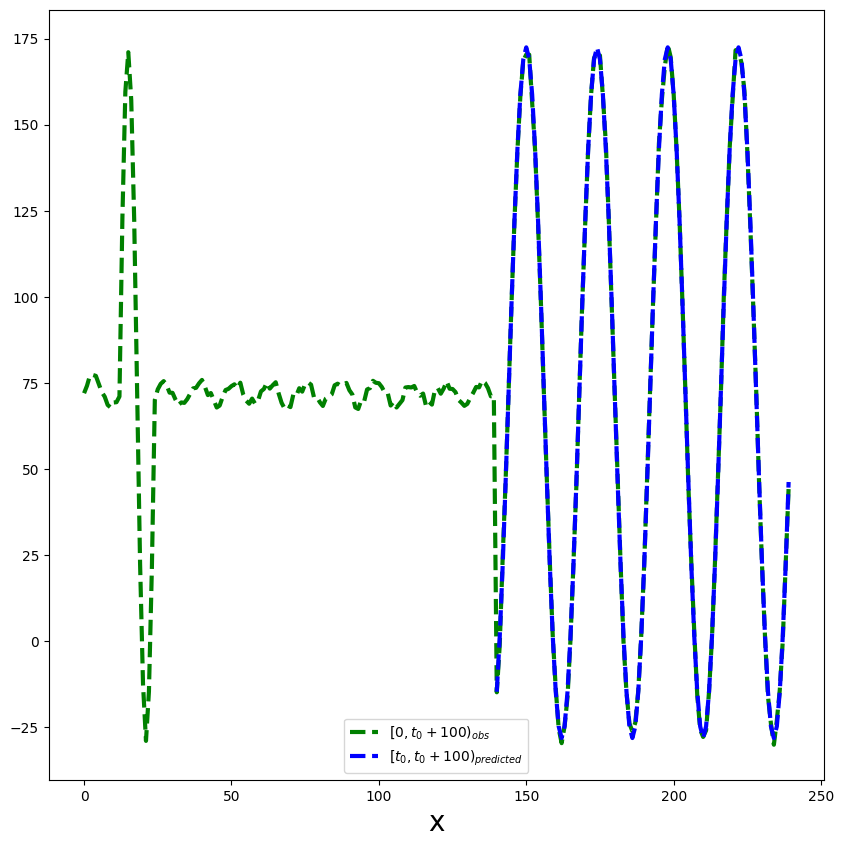

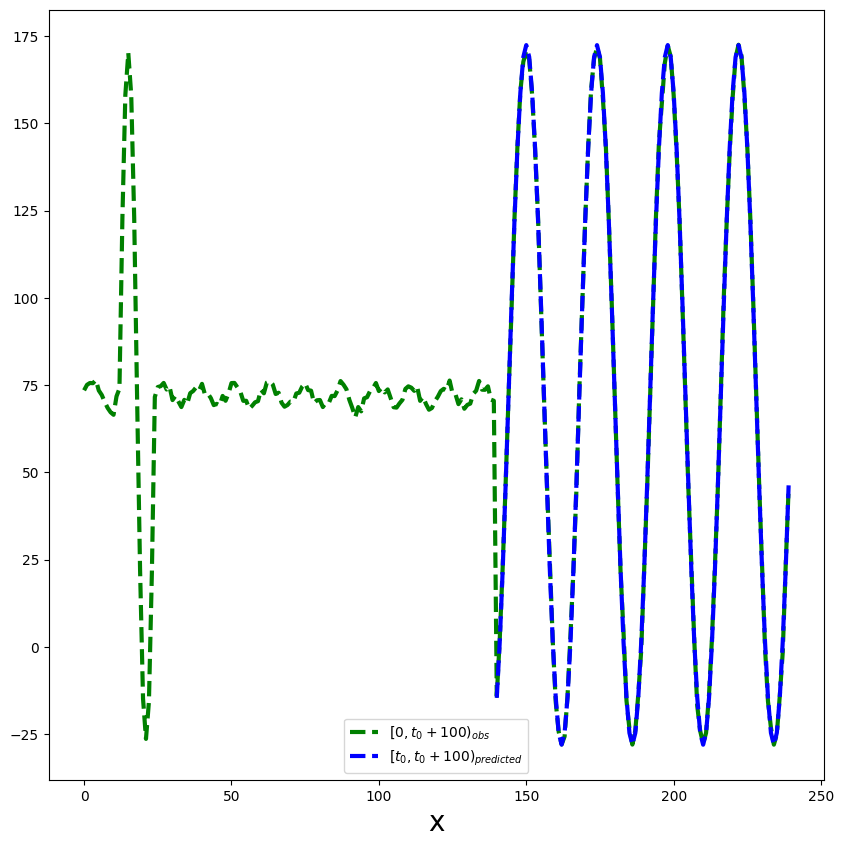

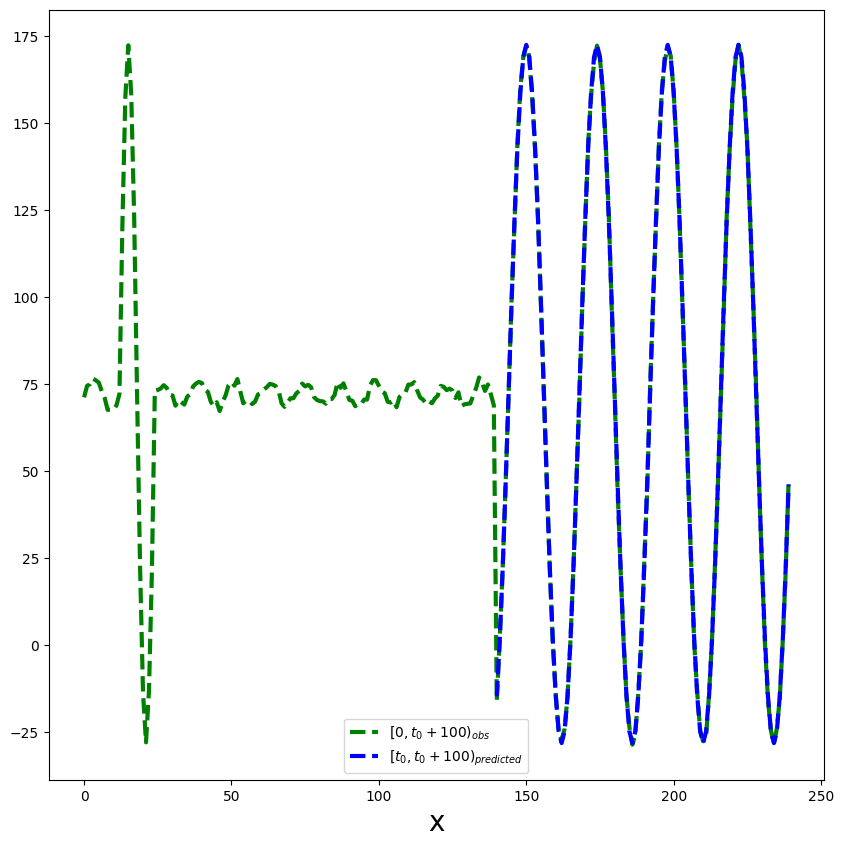

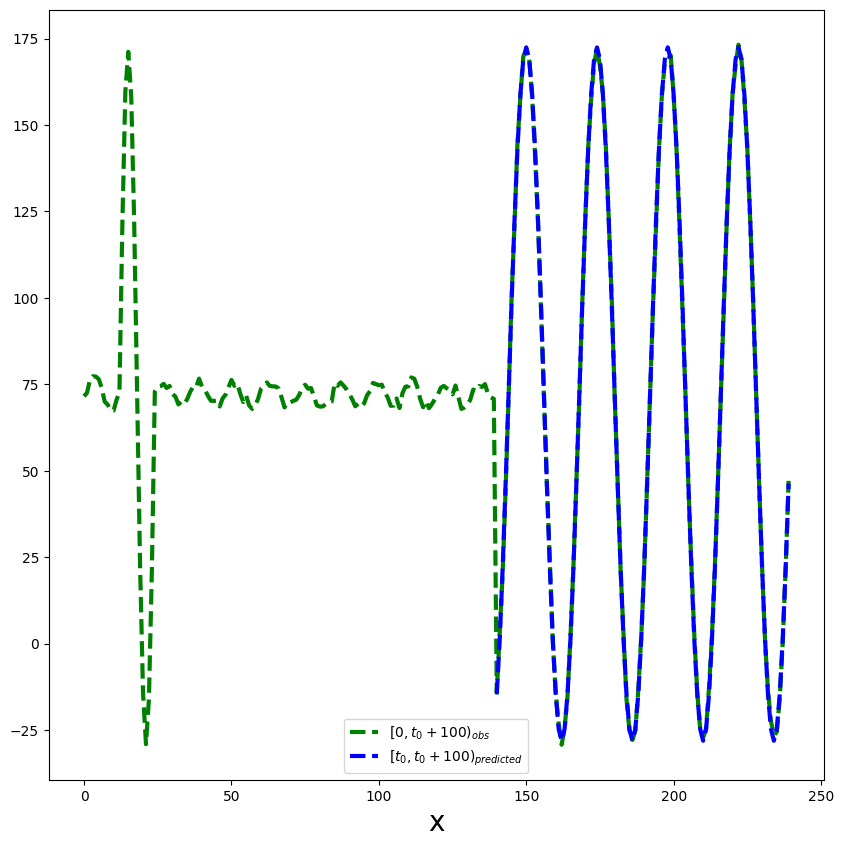

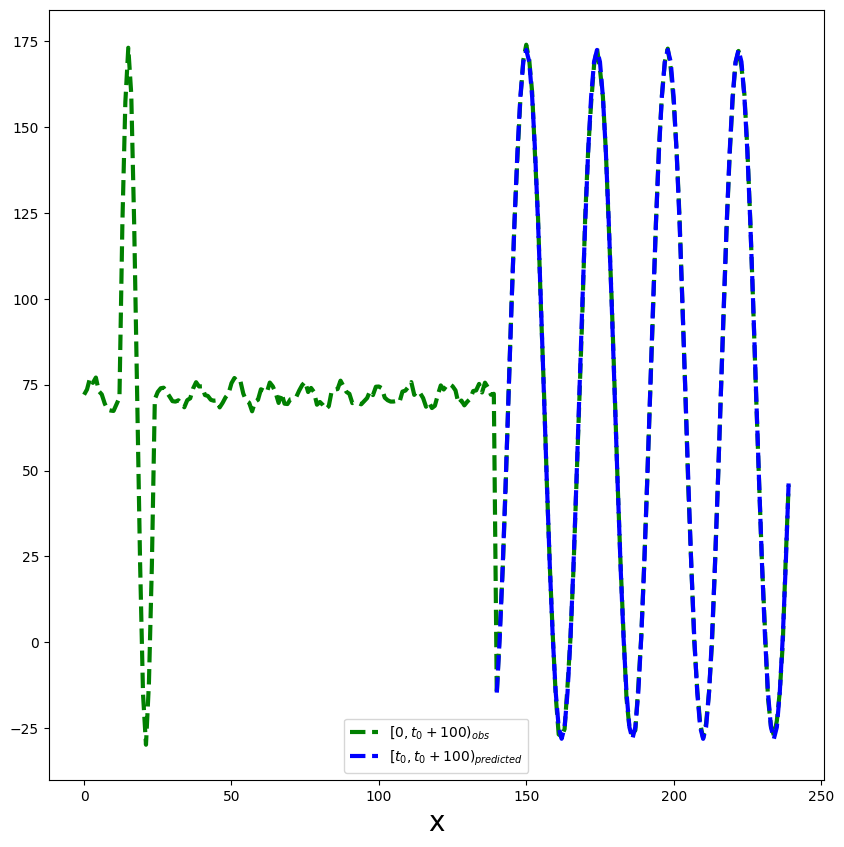

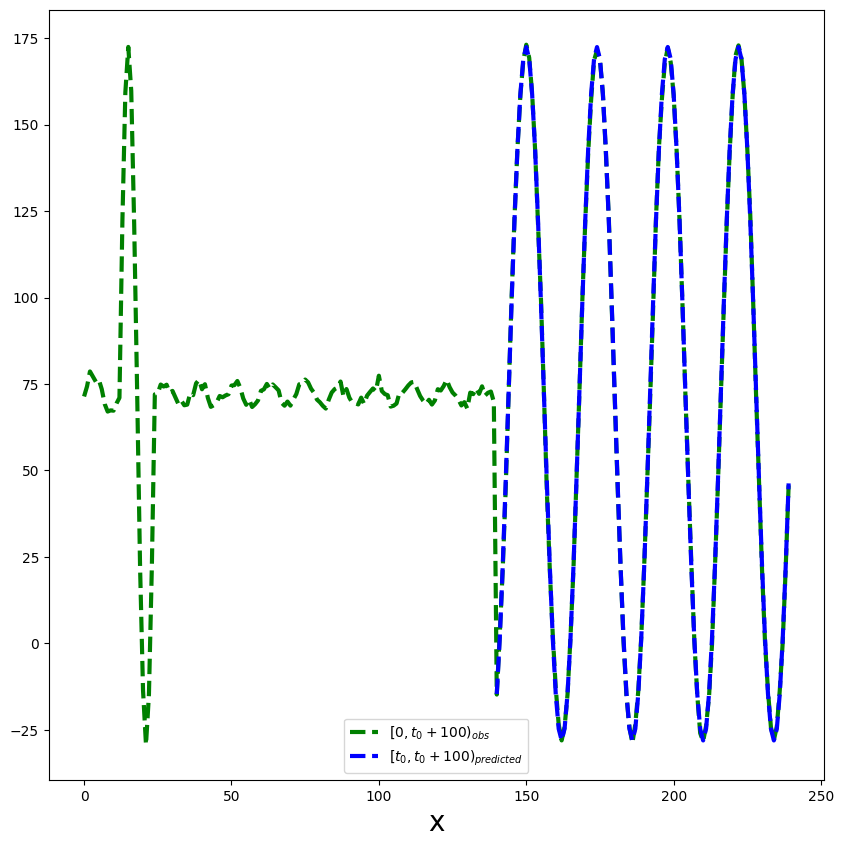

In [19]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
                plt.plot(x[0,t0:].cpu().detach().squeeze().numpy(),output[0,(t0-1):(t0+100-1)].cpu().detach().squeeze().numpy(),'b--',linewidth=3)
                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0+100)_{obs}$","$[t_0,t_0+100)_{predicted}$"])
                plt.show()


In [20]:
def get_attn(model,x,y,attention_masks):
    model.eval()
    with torch.no_grad():
        x=x.cuda(); y=y.cuda(); attention_masks = attention_masks.cuda()
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z_embedding = model.input_embedding(z).permute(2,0,1)
        positional_embeddings = model.positional_embedding(x.type(torch.long)).permute(1,0,2)
        input_embedding = z_embedding+positional_embeddings
                
        attn_layer_i = []
        for layer in model.transformer_decoder.layers:
            attn_layer_i.append(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].squeeze().cpu().detach().numpy())
            input_embedding = layer.forward(input_embedding,attention_masks)
        
        return attn_layer_i

In [21]:
idx_example = 90

In [22]:
attn_layers = get_attn(model,test_dataset[idx_example][0].unsqueeze(0),test_dataset[idx_example][1].unsqueeze(0),test_dataset[idx_example][2])

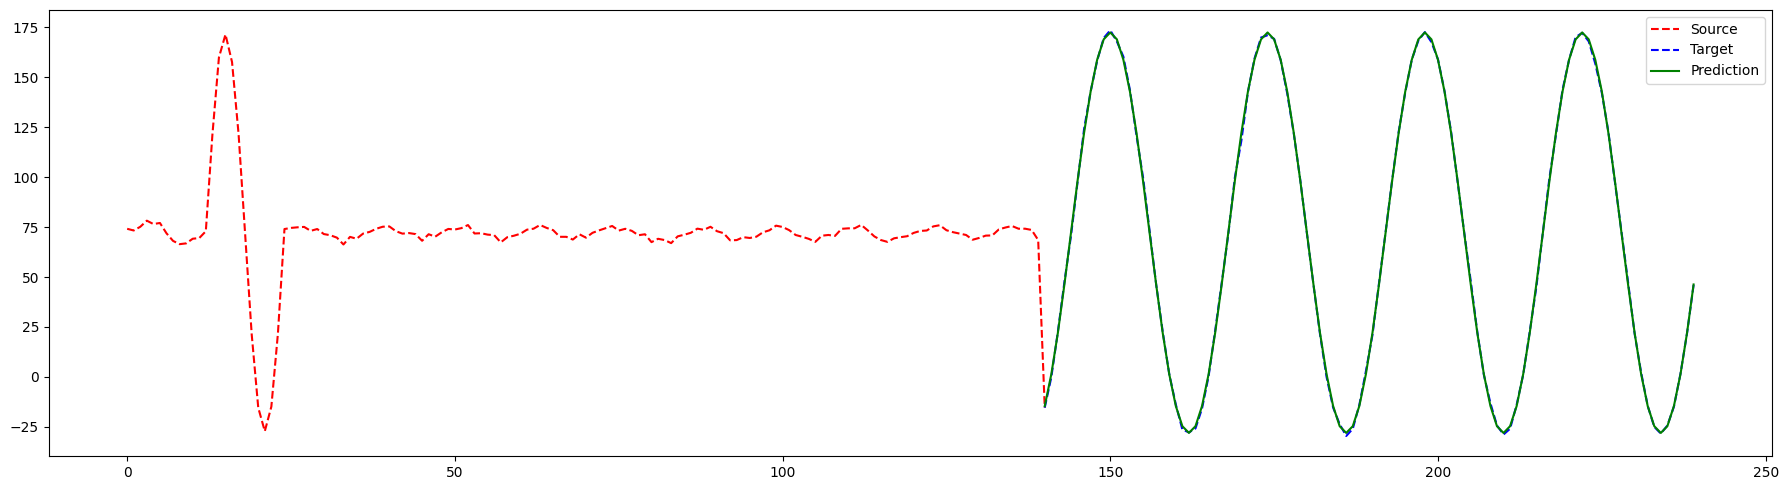

In [23]:
plt.figure(figsize=(18,5))

# Correct x-axis definitions
x_source = np.arange(t0+1)
x_target = np.arange(t0, t0 + 100)
x_pred = np.arange(t0, t0 + 100)

# Correct y values
source = test_dataset[idx_example][1][:t0+1].numpy()
target = test_dataset[idx_example][1][t0:t0+100].numpy() 
pred = predictions[idx_example]

# Plotting
plt.plot(x_source, source, 'r--', label='Source')
plt.plot(x_target, target, 'b--', label='Target')
plt.plot(x_pred, pred, 'g-', label='Prediction')

plt.legend()
plt.tight_layout()
plt.show()
